In [2]:
from torch import nn
import torch
import gym
import time
import numpy as np

In [3]:
env = gym.make("Pendulum-v0")



In [4]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(state_dim, 32),
                    nn.ReLU(),
                    nn.Linear(32,16),
                    nn.ReLU(),
                    nn.Linear(16,action_dim),
                    nn.Softmax()
                    )
    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(state_dim, 32),
                    nn.ReLU(),
                    nn.Linear(32,8),
                    nn.ReLU(),
                    nn.Linear(8,1)
                    )
    def forward(self, x):
        return self.net(x)

# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

In [5]:
state_dim = env.observation_space.shape[0]
action_dim = 5
action_discrete_space = np.array([[-2.2],[-0.6],[0.],[0.6],[2.2]])
gamma = 0.999
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

adam_actor = torch.optim.Adam(actor.parameters())
adam_critic = torch.optim.Adam(critic.parameters())



In [50]:
env.close()

In [7]:
episode_rewards = []
episode_steps = []
episode_time = []
episode_advantage = []
n_episodes = 1
max_steps = 200


for episode in range(n_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    step = 0
    start = time.time()
    advantage_total = []
    
    for _ in range(max_steps):
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs = probs)
        action = dist.sample()
        
        ix = action.detach().data.numpy()
        next_state, reward, done, info = env.step(action_discrete_space[ix])
        advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))
        
        total_reward += reward
        state = next_state
        step += 1
        
        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()        
        print(dist.log_prob(action))
        actor_loss = -dist.log_prob(action)*advantage.detach()
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step() 
        
        #env.render()
        if done:
            print('Finished')
            break
    
    episode_time.append(time.time() -  start)        
    episode_steps.append(step)
    episode_rewards.append(total_reward)
    
    print('episode={}, steps={}, total_reward={}, time={}'.format(episode, step, total_reward, time.time() -  start))
    
#env.close()

/home/emanuelsamir/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
tensor(-1.5982, grad_fn=<SqueezeBackward1>)
tensor(-1.6044, grad_fn=<SqueezeBackward1>)
tensor(-1.4581, grad_fn=<SqueezeBackward1>)
tensor(-1.6068, grad_fn=<SqueezeBackward1>)
tensor(-1.6062, grad_fn=<SqueezeBackward1>)
tensor(-1.5671, grad_fn=<SqueezeBackward1>)
tensor(-1.8406, grad_fn=<SqueezeBackward1>)
tensor(-1.2737, grad_fn=<SqueezeBackward1>)
tensor(-1.5029, grad_fn=<SqueezeBackward1>)
tensor(-1.2301, grad_fn=<SqueezeBackward1>)
tensor(-1.9655, grad_fn=<SqueezeBackward1>)
tensor(-1.9940, grad_fn=<SqueezeBackward1>)
tensor(-1.4476, grad_fn=<SqueezeBackward1>)
tensor(-1.2910, grad_fn=<SqueezeBackward1>)
tensor(-2.0196, grad_fn=<SqueezeBackward1>)
tensor(-1.4679, grad_fn=<SqueezeBackward1>)
tensor(-1.3766, grad_fn=<SqueezeBackward1>)
tensor(-1.9565, gr

In [63]:
actor(t(state))

tensor([0.7820, 0.1170, 0.1010], grad_fn=<SoftmaxBackward>)

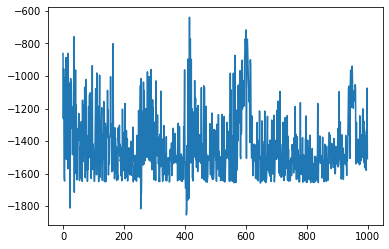

In [27]:
from matplotlib import pyplot as plt
plt.plot(episode_rewards)

In [34]:
env.reset()
for _ in range(max_steps):
    time.sleep(0.01)
    probs = actor(t(state))
    dist = torch.distributions.Categorical(probs = probs)
    action = dist.sample()
    

    ix = action.detach().data.numpy()
    
    next_state, reward, done, info = env.step(action_discrete_space[ix])
    advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))

    total_reward += reward
    state = next_state   
    env.render()
env.close()